# Global Diferential Privacy Assessement: Univariate case

In this notebook, we will explore the univariate case of the Global Differential Privacy using a dataset from use case 2.1. After running this notebook, you will be able to:
- Understand the concept of Global Differential Privacy.
- Apply Global Differential Privacy to a univariate dataset.

We also run a monte carl simulation to validate the GDP implementation.

## Import data and visualise

The data are imported and only available via 'pipelines' i.e. automations made by a user. As such GDP operates on the user pipeline and not directly on the data.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, shutil
!pip install wget
import wget

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [2]:
os.makedirs("data", exist_ok=True)
link_original = "https://s3.amazonaws.com/openneuro.org/ds004148/participants.tsv?versionId=wt81Mu2B3fdeiXSis5ym288A64lXRXkR"
wget.download(link_original)
filename = "participants.tsv"
file_ = [os.path.join(root, file) for root, _, files in os.walk(os.getcwd()) for file in files if file == filename]
shutil.copy2(file_[0], "data")
os.remove(file_[0])
print(f"\nOriginal file downloaded.")

data = np.array(pd.read_csv("data/"+filename,sep='\s+')["Height"]).reshape(-1,1)
clean_data = data[~np.isnan(data)]
print(f"\n\tClean data: {clean_data}")

100% [..........................................................] 39886 / 39886
Original file downloaded.

	Clean data: [178.   155.   169.   157.   171.   166.   167.   175.   165.   160.
 160.   156.   155.   162.   168.   165.   163.   164.   172.   180.
 160.   160.   160.   174.   162.   164.   173.   168.   160.   160.
 170.   185.   177.   177.   182.   175.   165.   175.   180.   165.
  58.   185.     1.65 167.   153.   174.   173.   175.   167.   170.
 178.   185.   172.   157.   172.   157.   171.   163.  ]


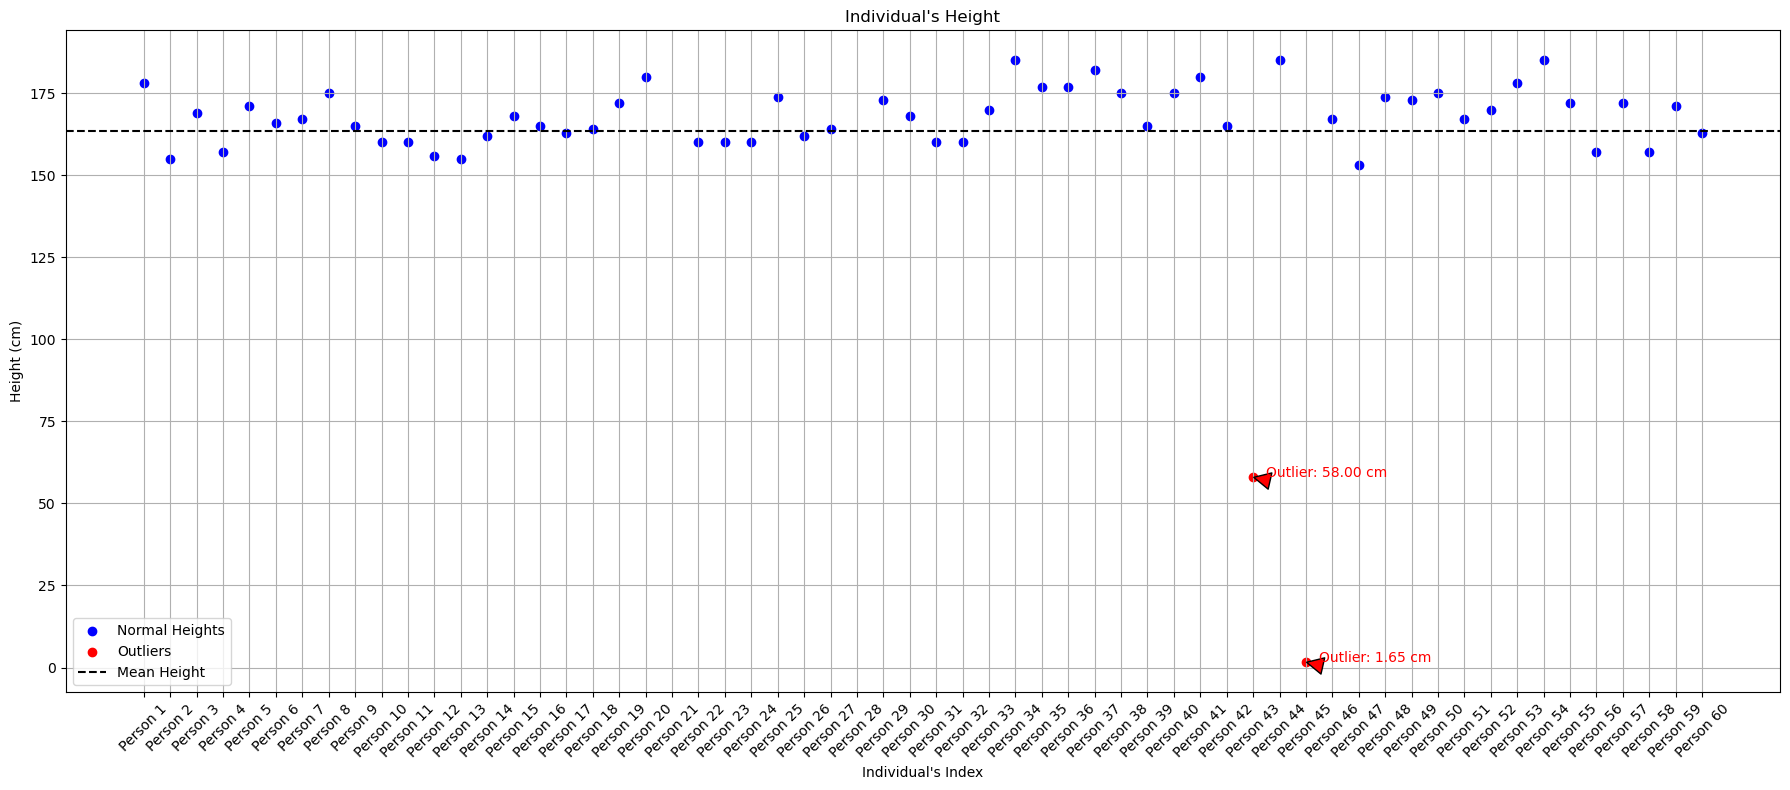

In [3]:
data = np.array(pd.read_csv("data/"+filename,sep='\s+')["Height"]).reshape(-1,1)

clean_data = data[~np.isnan(data)]
q1 = np.percentile(clean_data, 25)
q3 = np.percentile(clean_data, 75)
iqr = q3 - q1
lower_bound = q1 - 1.5*iqr
upper_bound = q3 + 1.5*iqr

outlier_indices = np.where((data < lower_bound) | (data > upper_bound))[0]
plt.figure(figsize=(18, 8))
normal_indices = [i for i in range(len(data)) if i not in outlier_indices]
plt.scatter(normal_indices, data[normal_indices], color='blue', label='Normal Heights')
plt.scatter(outlier_indices, data[outlier_indices], color='red', label='Outliers')

for outlier_idx in outlier_indices:
    plt.annotate(f'Outlier: {data[outlier_idx][0]:.2f} cm',
                xy=(outlier_idx, data[outlier_idx]),
                xytext=(outlier_idx+0.5, data[outlier_idx]),
                arrowprops=dict(facecolor='red', shrink=0.05),
                color='red')
plt.axhline(np.nanmean(data), color='black', linestyle='--', label='Mean Height')
plt.title("Individual's Height")
plt.xlabel("Individual's Index")
plt.xticks(range(len(data)), [f"Person {i + 1}" for i in range(len(data))], rotation=45)
plt.ylabel("Height (cm)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Global Differential Privacy

Global Differential Privacy (DP) is a mathematical framework that provides strong, quantifiable privacy guarantees when analyzing and sharing data. Its core idea is to ensure that the inclusion or exclusion of a single individual’s data does not significantly affect the output of an analysis, thereby limiting what can be inferred about any one person. This limits the ability of an attacker to infer whether someone participated in the dataset, even if they possess additional background information. To achieve this, DP algorithms inject calibrated random noise into outputs.

## User Output

A data user has an analysis pipeline that s run on the data. The output of such pipeline is then made differentially private.

Here, the pipeline simply consists in computing the mean.


In [4]:
def user_output(clean_data):

    pipeline_output = np.mean(clean_data)
    return pipeline_output

In [5]:
pipeline_output = user_output(clean_data)
print("the true mean is: ", user_output(clean_data))

the true mean is:  163.42499999999998


## GDP algorithm

The procedure take the user pipeline and data and applies a leave one out (loo) resampling to the data to obtain the influence function, i.e. the output of the user pipeline for each loo resample are compared to the user output. The maximum of that gives the lower bound of the noise to be applied (i.e. it provides the information on the observation which has the largest influence).  



In [6]:
loo_data = np.array([np.delete(clean_data, i) for i in range(len(clean_data))])
print(f"\n\tall loo data: {loo_data}")


	all loo data: [[155. 169. 157. ... 157. 171. 163.]
 [178. 169. 157. ... 157. 171. 163.]
 [178. 155. 157. ... 157. 171. 163.]
 ...
 [178. 155. 169. ... 172. 171. 163.]
 [178. 155. 169. ... 172. 157. 163.]
 [178. 155. 169. ... 172. 157. 171.]]


In [7]:
loo_output = np.array([user_output(np.delete(clean_data, i)) for i in range(len(clean_data))])
print(f"\n\tall loo output values: {loo_output}")
print(f"\n\tloo for outliers: {loo_output[outlier_indices]}")


	all loo output values: [163.16929825 163.57280702 163.32719298 163.5377193  163.29210526
 163.37982456 163.3622807  163.22192982 163.39736842 163.48508772
 163.48508772 163.55526316 163.57280702 163.45       163.34473684
 163.39736842 163.43245614 163.41491228 163.2745614  163.13421053
 163.48508772 163.48508772 163.48508772 163.23947368 163.45
 163.41491228 163.25701754 163.34473684 163.48508772 163.48508772
 163.30964912 163.04649123 163.18684211 163.18684211 163.09912281
 163.22192982 163.39736842 163.22192982 163.13421053 163.39736842
 165.2745614  163.04649123 166.26315789 163.3622807  163.60789474
 163.23947368 163.25701754 163.22192982 163.3622807  163.30964912
 163.16929825 163.04649123 163.2745614  163.5377193  163.2745614
 163.5377193  163.29210526 163.43245614]

	loo for outliers: [166.26315789 163.60789474]


In [8]:
sensitivity = np.max(np.abs(loo_output - pipeline_output))
print(f"\n\tsensitivity: {sensitivity}")


	sensitivity: 2.8381578947368666


## Sampling from a noise distribution

Of course the noise value has to come from somewhere. Here we choose a Laplace distribution centred on 0 with the scale equal to variance of loo means, ie reflecting how much change we have due to single observations.

In [9]:
loo_scale = np.std(loo_output)
print(f"\n\tnoise scale: {loo_scale}")

while True:
    noise = np.random.laplace(loc=0.0, scale=loo_scale)
    if abs(noise) >= sensitivity:
        break
print(f"\n\tnoise: {noise}")
dgp_resut = pipeline_output + noise;
print(f"\n\tdgp result: {dgp_resut}")


	noise scale: 0.47422918086144344

	noise: -3.0907994268692485

	dgp result: 160.33420057313074


## Validation

Here we use monte carlo simulations to show that the results are differentially private.
Since GDP is defined by the influence of a single observation, we generate 1000 datasets of 20, 40, 60, 80, 100 people with one outlier. For each replicat, the user is asking for leave-one-out means, which will allow for the reconstruction of the data if it is not noisy (see notebook 1). Here, for each of those outpouts, noise is added, and we show that the user cannot reconstruct the data nor even identify outliers.

We compute the ability to find the outlier (for instance, in my sample of subjets, I wonder if my neighbour who has dwarfism participated to the study) but also look at the property of results (mean error of reconstructing data vs sensitivity)

we start by defining the object dp, which simply add noise as explained above, and reuse this for the user outputs

In [10]:
def dp(clean_data,pipeline_output):

    loo_output = np.array([user_output(np.delete(clean_data, i)) for i in range(len(clean_data))])
    loo_scale = np.std(loo_output)
    sensitivity = np.max(np.abs(loo_output - pipeline_output))
    while True:
        noise = np.random.laplace(loc=0.0, scale=loo_scale)
        if abs(noise) >= sensitivity:
            break

    noisy_output = pipeline_output + noise
    return noisy_output, sensitivity

## Run the monte carlo simulations

In [19]:
iqr_original_sims = []
bounds_original_sims = []
iqr_outlier_sims = []
bounds_outlier_sims = []
loo_original_sims = []
loo_outlier_sims = []
noisy_original_outputs_sims = []
sensitivity_original_sims = []
noisy_outlier_outputs_sims = []
sensitivity_outlier_sims = []


n_replicates = 1000
subsample_sizes = [20, 40, 60, 80, 100]
c = 0
for _ in range(n_replicates):
    # Generate new synthetic data for each simulation
    synthetic_data = np.random.normal(loc=170, scale=10, size=100)

    iqr_original_sim = []
    bounds_original_sim = []
    iqr_outlier_sim = []
    bounds_outlier_sim = []
    loo_original_sim = []
    loo_outlier_sim = []
    noisy_original_outputs_sim = []
    sensitivity_original_sim = []
    noisy_outlier_outputs_sim = []
    sensitivity_outlier_sim = []


    for size in subsample_sizes:
        # Original subsample without outlier
        original_subsample = synthetic_data[:size].copy()
        q1_orig = np.percentile(original_subsample, 25)
        q3_orig = np.percentile(original_subsample, 75)
        iqr_orig = q3_orig - q1_orig
        lower_bound_orig = q1_orig - 1.5 * iqr_orig
        upper_bound_orig = q3_orig + 1.5 * iqr_orig
        iqr_original_sim.append(iqr_orig)
        bounds_original_sim.append((lower_bound_orig, upper_bound_orig))

        # Generate leave one out data for the original subsample
        loo_original_subsample = np.array([np.delete(original_subsample, i) for i in range(len(original_subsample))])
        loo_original_sim.append(loo_original_subsample)

        # Calculate user_output and apply dp for original subsample LOO data
        noisy_outputs = []
        sensitivities = []
        for loo_data_subset in loo_original_subsample:
            output = user_output(loo_data_subset)
            noisy_output, sensitivity = dp(loo_data_subset, output)
            noisy_outputs.append(noisy_output)
            sensitivities.append(sensitivity)
        noisy_original_outputs_sim.append(noisy_outputs)
        sensitivity_original_sim.append(sensitivities)


        # Subsample with outlier
        subsample_with_outlier = original_subsample.copy()
        outlier_value = lower_bound_orig - 10  # Assign a value significantly below the lower bound
        subsample_with_outlier[0] = outlier_value  # Change the first element to the outlier value

        q1_outlier = np.percentile(subsample_with_outlier, 25)
        q3_outlier = np.percentile(subsample_with_outlier, 75)
        iqr_outlier_val = q3_outlier - q1_outlier
        lower_bound_outlier = q1_outlier - 1.5 * iqr_outlier_val
        upper_bound_outlier = q3_outlier + 1.5 * iqr_outlier_val
        iqr_outlier_sim.append(iqr_outlier_val)
        bounds_outlier_sim.append((lower_bound_outlier, upper_bound_outlier))

        # Generate leave one out data for the subsample with outlier
        loo_outlier_subsample = np.array([np.delete(subsample_with_outlier, i) for i in range(len(subsample_with_outlier))])
        loo_outlier_sim.append(loo_outlier_subsample)

        # Calculate user_output and apply dp for outlier subsample LOO data
        noisy_outputs = []
        sensitivities = []
        for loo_data_subset in loo_outlier_subsample:
            output = user_output(loo_data_subset)
            noisy_output, sensitivity = dp(loo_data_subset, output)
            noisy_outputs.append(noisy_output)
            sensitivities.append(sensitivity)
        noisy_outlier_outputs_sim.append(noisy_outputs)
        sensitivity_outlier_sim.append(sensitivities)
        ########### Reconstruction part
        n = size
        recons = np.linalg.solve(np.ones((n, n)) - np.eye(n), (n-1) * np.array(noisy_outputs).flatten())
        if subsample_with_outlier[0] == recons[0]:
            print(f"Reconstruction was successful. Sensitivity: {sensitivities}")
        c += 1 if subsample_with_outlier[0] == recons[0] else 0

    iqr_original_sims.append(iqr_original_sim)
    bounds_original_sims.append(bounds_original_sim)
    iqr_outlier_sims.append(iqr_outlier_sim)
    bounds_outlier_sims.append(bounds_outlier_sim)
    loo_original_sims.append(loo_original_sim)
    loo_outlier_sims.append(loo_outlier_sim)
    noisy_original_outputs_sims.append(noisy_original_outputs_sim)
    sensitivity_original_sims.append(sensitivity_original_sim)
    noisy_outlier_outputs_sims.append(noisy_outlier_outputs_sim)
    sensitivity_outlier_sims.append(sensitivity_outlier_sim)

# reconstruct data for each subsample and check if outlier can be found and compute mean reconstruction error
# return percentage of outlier correctly identified and plot sensitivty vs mean reconstruction error
print(f"{(c / n_replicates) *100}% reconstructed successfully.")

0.0% reconstructed successfully.


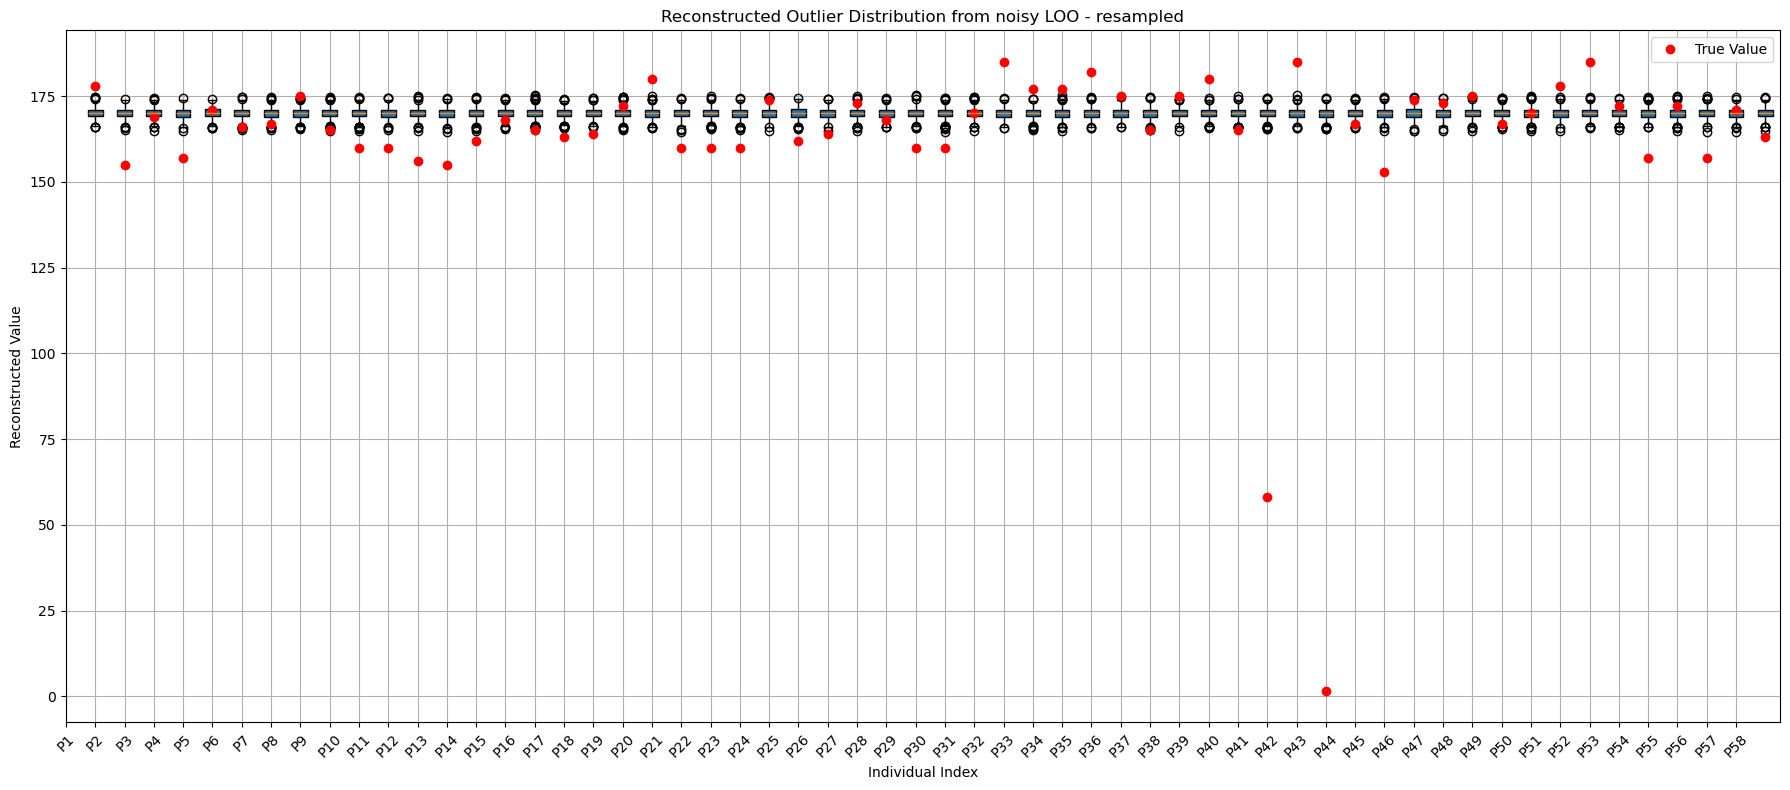

In [20]:
test = np.array([noisy_original_outputs_sims[i][2][:58] for i in range(1000)])
plt.figure(figsize=(18, 8))
plt.boxplot(test, labels=[f"Person {i+1}" for i in range(58)], patch_artist=True)
plt.plot(range(1, 58+1), clean_data, 'ro', label="True Value") 
plt.title("Reconstructed Outlier Distribution from noisy LOO - resampled")
plt.xlabel("Individual Index")
indices = np.arange(len(clean_data))
plt.xticks(indices, [f"P{i + 1}" for i in indices], rotation=45)
plt.ylabel("Reconstructed Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Comparison to local privacy

Local privacy is something that one is more accustomed to. We simply have to add noise on each subject. Of course in project in which the data are completely private this is not possible, which is why gobal privacy can be used. It is however beneficial to compare the approach and results here.

We start by creating the local_dp object which noise data rahter than user_output

In [21]:
def local_dp(clean_data):

    # now this is simply how far a subject is to the user_output
    sensitivity = np.abs(clean_data-pipeline_output)

    noise_values = np.zeros_like(clean_data)
    for i in range(len(clean_data)):
        while True:
            noise = np.random.laplace(loc=0.0, scale=sensitivity[i])
            if abs(noise) >= sensitivity[i]:
                noise_values[i] = noise
                break

    noisy_data = clean_data + noise_values
    return noisy_data, sensitivity

In [22]:
noisy_data = local_dp(clean_data)
print(noisy_data)

(array([120.75640816, 172.80452079, 160.26462241, 145.54331761,
       159.5113452 , 169.42236212, 171.64227395, 149.64378673,
       160.92966075, 155.30282609, 155.22294037, 147.58772339,
       198.76854782, 160.24792873, 162.94472924, 167.61358059,
       163.52629931, 163.19377334, 162.73699356, 152.27578145,
       165.87102323, 164.22634768, 167.24574295, 209.21782399,
       168.91298096, 162.83060466, 162.32775453, 162.71222267,
       154.14140308, 154.73767741, 153.77172584, 222.86504517,
       152.292592  , 193.4074587 , 212.46752532, 133.52979496,
       167.47655997, 193.19463155, 139.50913387, 169.2136413 ,
       175.5328681 , 146.10618938, 522.37722983, 175.25307595,
       178.80647743, 187.35905185, 155.15688915, 187.32361226,
       174.0764868 , 156.011931  , 197.6656149 , 116.00363736,
       153.76754898, 166.13093719, 184.18712017, 165.17140896,
       186.39970341, 163.7653188 ]), array([ 14.575,   8.425,   5.575,   6.425,   7.575,   2.575,   3.575,
        11